In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
import os
import cv2
from PIL import Image



In [ ]:
# U-Net model definition
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.encoder2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.encoder4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) 
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) 
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)   

        # Additional convolutional layers after concatenation to reduce channel sizes
        self.conv4 = nn.Conv2d(768, 256, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(384, 128, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(192, 64, kernel_size=3, padding=1)  
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  

        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        # Bottleneck (no pooling)
        mid = self.pool(enc4)

        # Decoder path (upsampling and concatenation)
        dec4 = self.upconv4(mid)
        dec4_resized = F.interpolate(dec4, size=enc4.shape[2:], mode='bilinear', align_corners=False)
        dec4 = torch.cat([dec4_resized, enc4], dim=1)
        dec4 = self.conv4(dec4)  


        dec3 = self.upconv3(dec4)
        dec3_resized = F.interpolate(dec3, size=enc3.shape[2:], mode='bilinear', align_corners=False)
        dec3 = torch.cat([dec3_resized, enc3], dim=1)
        dec3 = self.conv3(dec3)  

        dec2 = self.upconv2(dec3)
        dec2_resized = F.interpolate(dec2, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat([dec2_resized, enc2], dim=1)
        dec2 = self.conv2(dec2)  

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)  # Concatenate encoder and decoder
        dec1 = self.conv1(dec1)  

        # Final output
        return self.final(dec1)

In [ ]:
# Custom dataset class
class GlacierDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(images_dir))
        self.mask_paths = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_paths[idx]))
        mask = Image.open(os.path.join(self.masks_dir, self.mask_paths[idx]))

        # Convert to grayscale for segmentation (single channel)
        mask = mask.convert('L')  # Convert the mask to grayscale (1 channel)
        
        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure the mask has the correct shape [1, height, width]
        mask = mask.unsqueeze(0)  # Add a channel dimension: [1, height, width]

        # Squeeze out any extra dimensions (if they exist)
        mask = mask.squeeze(0)  # This will remove any unnecessary dimensions

        return image, mask

In [ ]:
# Helper function to calculate IOU
def calculate_iou(pred_mask, true_mask):
    # Ensure both masks are binary
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    true_mask = (true_mask > 0.5).astype(np.uint8)

    # Resize pred_mask to match true_mask shape (height, width)
    pred_mask_resized = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Compute Intersection and Union
    intersection = np.logical_and(pred_mask_resized, true_mask)
    union = np.logical_or(pred_mask_resized, true_mask)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [ ]:
# Training function
def train_model(model, train_loader, device, num_epochs=2, lr=0.001):
    criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy loss for segmentation
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)

            # Ensure masks have the correct shape [batch_size, 1, height, width]
            masks = masks.unsqueeze(1)  # Ensure mask has 1 channel
            if masks.dim() > 4:
                masks = masks.squeeze(1)  # Remove extra dimensions if any

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.float())  # Ensure mask is float

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


In [ ]:
def calculate_difference_area(pred_mask, true_mask):
    """
    Calculate the area difference between the predicted mask and the true mask.
    This function calculates the number of pixels that differ between the two masks.

    Args:
        pred_mask (np.ndarray): The predicted binary mask.
        true_mask (np.ndarray): The true binary mask.

    Returns:
        diff_area (int): The total number of pixels that have changed between the two masks.
    """
    # Ensure the masks are binary (0 or 1)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    true_mask = (true_mask > 0.5).astype(np.uint8)

    # Calculate pixel-wise difference (using XOR-like logic)
    diff_area = np.sum(np.abs(pred_mask - true_mask))  # Number of pixels that differ
    return diff_area

In [ ]:

def visualize_and_calculate(before_image_path, after_image_path, model, device):
    before_image = Image.open(before_image_path)
    after_image = Image.open(after_image_path)

    # Convert images to RGB (in case they are in RGBA or another mode)
    before_image = before_image.convert('RGB')
    after_image = after_image.convert('RGB')

    # Preprocessing and transforming images to tensor
    transform = transforms.Compose([
        transforms.Resize((400, 400)),  # Ensure images are of the same size (adjust as needed)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    before_image = transform(before_image).unsqueeze(0).to(device)
    after_image = transform(after_image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        # Forward pass for before and after images
        before_output = model(before_image)
        after_output = model(after_image)
        
        # Apply sigmoid and squeeze batch dimension
        before_mask = torch.sigmoid(before_output).squeeze(0).cpu().numpy()
        after_mask = torch.sigmoid(after_output).squeeze(0).cpu().numpy()

        # Thresholding to create binary masks
        before_mask = (before_mask > 0.5).astype(np.uint8)
        after_mask = (after_mask > 0.5).astype(np.uint8)

        # Print out shapes for debugging
        print(f"Before Mask Shape: {before_mask.shape}")
        print(f"After Mask Shape: {after_mask.shape}")

        # Resize the before_mask to match the after_mask
        before_mask_resized = cv2.resize(before_mask, (after_mask.shape[1], after_mask.shape[0]), interpolation=cv2.INTER_LINEAR)

        # Calculate IoU
        iou_score = calculate_iou(after_mask, before_mask_resized)
        print(f"IOU Score: {iou_score:.4f}")

        # Calculate the difference area
        res= 30
        diff_area = calculate_difference_area(after_mask, before_mask_resized) 
        total_area = diff_area * res
        print(f"Difference Area: {diff_area} pixels")
        print(f"Total Area: {total_area} m^2")

        # Visualize the results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(before_image.squeeze(0).permute(1, 2, 0).cpu())
        plt.title("Before Image")
        plt.subplot(1, 3, 2)
        plt.imshow(after_image.squeeze(0).permute(1, 2, 0).cpu())
        plt.title("After Image")
        
        # Squeeze the extra dimension before plotting the mask
        plt.subplot(1, 3, 3)
        plt.imshow(after_mask.squeeze(), cmap='gray')  # Removed the extra dimension
        plt.title("After Mask Prediction")
        plt.show()

In [ ]:
# Data directories
train_images_dir = 'data/images'
train_masks_dir = 'data/masks'

# Transform for the images
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # Resize images to the same size for consistency
    transforms.ToTensor(),
])

In [ ]:
# Dataset and DataLoader
train_dataset = GlacierDataset(train_images_dir, train_masks_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
# Model setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)

Epoch 1/10: 100%|██████████| 103/103 [00:59<00:00,  1.73it/s]


Epoch 1/10, Loss: 2.68669610850296


Epoch 2/10: 100%|██████████| 103/103 [00:57<00:00,  1.78it/s]


Epoch 2/10, Loss: 0.25097648933240513


Epoch 3/10: 100%|██████████| 103/103 [01:06<00:00,  1.54it/s]


Epoch 3/10, Loss: 0.10709350623045731


Epoch 4/10: 100%|██████████| 103/103 [01:20<00:00,  1.28it/s]


Epoch 4/10, Loss: 0.10264329556194902


Epoch 5/10: 100%|██████████| 103/103 [01:18<00:00,  1.31it/s]


Epoch 5/10, Loss: 0.10129999944451944


Epoch 6/10: 100%|██████████| 103/103 [01:20<00:00,  1.29it/s]


Epoch 6/10, Loss: 0.10091097045291975


Epoch 7/10: 100%|██████████| 103/103 [01:18<00:00,  1.32it/s]


Epoch 7/10, Loss: 0.10148577133501038


Epoch 8/10: 100%|██████████| 103/103 [01:23<00:00,  1.23it/s]


Epoch 8/10, Loss: 0.1006103673027557


Epoch 9/10: 100%|██████████| 103/103 [01:20<00:00,  1.29it/s]


Epoch 9/10, Loss: 0.09732450698547572


Epoch 10/10: 100%|██████████| 103/103 [01:18<00:00,  1.31it/s]


Epoch 10/10, Loss: 0.09800413455271605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..1.9951199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.2216995].


Before Mask Shape: (1, 400, 400)
After Mask Shape: (1, 400, 400)
IOU Score: 0.6858
Difference Area: 6361286 pixels
Total Area: 190838580.0 m^2


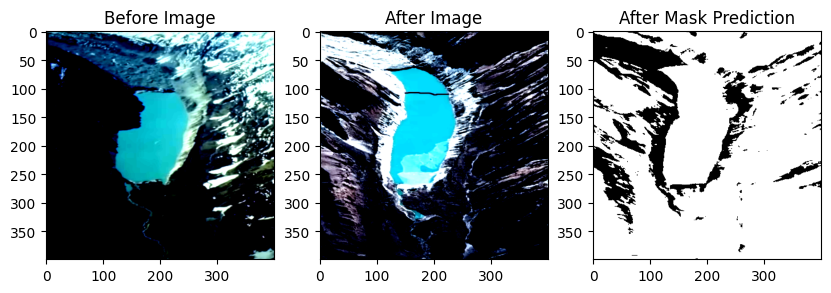

In [ ]:
# Training the model
train_model(model, train_loader, device, num_epochs=10)

# Visualize results
before_image_path = 'data/test/before.png'
after_image_path = 'data/test/after.png'
visualize_and_calculate(before_image_path, after_image_path, model, device)